# Understanding Overfitting and Underfitting

When building machine learning models, one of the primary challenges is to ensure that the model generalizes well to new, unseen data. We can measure how well the model generalises using independent Test set. Some of the evaluation metrics that can be used to measure performance on test set are : 
- prediction accuracy
- mis-classification error

Simply we say that a good model has - 
- high generalization accuracy
- low generalization error

**Now, overfitting and underfitting are two terms that we can use to diagnose a machine learning model based on the training and test set performance**

## Overfitting

Overfitting occurs when a model learns the training data too well, capturing noise and details that do not generalize to unseen data. This usually happens when the model is too complex, such as having too many parameters relative to the number of observations. 

If we say in very simple and concise language : Overfitting occurs when model starts fitting the noise. It thinks noise also to be an important structure of data that needs to get modelled. This happens because the model is too complex(more parameters than required) for data.

### Indicators of Overfitting

- **Low Training Error, High Test Error**
- **High Training Accuracy, Low Test Accuracy**
- **The model performs exceptionally well on training data but poorly on validation/test data**
- **Complex Model**: The model may have large number of parameters. For eg: Higher order polynomial fitting simple data.

### Visual Example

<img src="https://keeeto.github.io/assets/images/Overfitting.png" alt="Overfitting Example" width="430px">

[Image Source : keeto.github.io](https://keeeto.github.io/blog/bias_variance/)


### How to Address Overfitting

1. **Simplify the Model**: Reduce the complexity of the model by decreasing the number of features or parameters.
2. **Regularization**: Techniques like L1 or L2 regularization can penalize large coefficients, helping to prevent overfitting.
3. **More Data**: Increasing the size of the training dataset can help the model to generalize better.

## Underfitting

### What is Underfitting?

Underfitting occurs when a model is too simple to capture the underlying structure of the data. This usually happens when the model has too few parameters, making it unable to learn the patterns in the data.

If we say in very simple and concise language : Underfitting occurs when model starts almost everything as noise. It does not fit the actual structure for given data leave about noise. This happens when the model has less number of parameters so that it is not powerful enough to model given data's structure. 

### Indicators of Underfitting

- **High Training Error, High Validation/Test Error**
- **low Training Accuracy, Low Test Accuracy**
- **The model performs poorly on both training and validation/test data.**
- **Simple Model**: The model may have too few features or parameters, making it incapable of capturing complexities in the data.

### Visual Example
<img src="https://keeeto.github.io/assets/images/Underfitting.png" alt="Overfitting Example" width="430px">

[Image Source : keeto.github.io](https://keeeto.github.io/blog/bias_variance/)

### How to Address Underfitting

1. **Increase Model Complexity**: Add more features or parameters to the model.
2. **Feature Engineering**: Create new features that can help capture the underlying patterns in the data.
3. **Reduce Bias**: Use techniques to reduce the bias in the model.

## Finding the Right Balance

The goal is to find a balance between overfitting and underfitting, which is often referred to as the bias-variance tradeoff. 
**Bias** refers to errors due to overly simplistic models, while **variance** refers to errors due to overly complex models.



In [1]:
# Numpy and pandas as usual
import numpy as np
import pandas as pd

# Scikit-Learn for fitting models
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

# For plotting in the notebook
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# Default parameters for plots
matplotlib.rcParams['font.size'] = 12
matplotlib.rcParams['figure.titlesize'] = 16
matplotlib.rcParams['figure.figsize'] = [8, 6]

import warnings
warnings.filterwarnings("ignore")

# Data Generation for Polynomial Regression Example
we generate the dataset that will be used to demonstrate the concepts of overfitting and underfitting in polynomial regression. We set the random seed to 42 using `np.random.seed(42)` to ensure reproducible results. This allows us to generate the same random numbers each time the code is run.

**Underlying distribution or Generating Function**:
   - In our case, the underlying function from which data comes is defined as a sine function: \( y = \sin(2\pi x) \).
   - We generate 120 `x` values uniformly distributed between 0 and 1, sorted in ascending order.
   - The corresponding `y` values are calculated using the true generating function and then a small amount of Gaussian noise is added.


In [2]:
np.random.seed(42)

# "True" generating function representing a process in real life
# def true_gen(x):
#     y = np.sin(1.2 * x * np.pi) 
#     return(y)

def true_gen(x):
    y = np.sin(2 * np.pi * x) 
    return y

x = np.sort(np.random.rand(120))
y = true_gen(x) + 0.1 * np.random.randn(len(x))

In [3]:
# Random indices for creating training and testing sets
random_ind = np.random.choice(list(range(120)), size = 120, replace=False)
xt = x[random_ind]
yt = y[random_ind]

# Training and testing observations
train = xt[:int(0.7 * len(x))]
test = xt[int(0.7 * len(x)):]

y_train = yt[:int(0.7 * len(y))]
y_test = yt[int(0.7 * len(y)):]

# Model the true curve
x_linspace = np.linspace(0, 1, 1000)
y_true = true_gen(x_linspace)

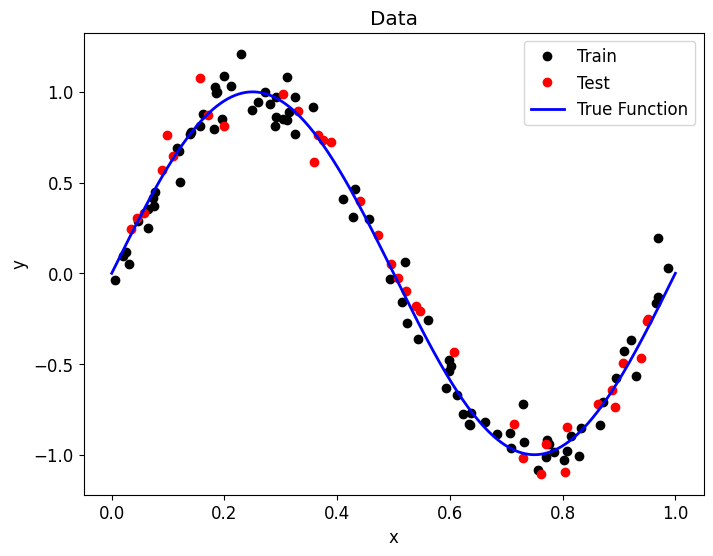

In [4]:
# Visualize observations and true curve
plt.plot(train, y_train, 'ko', label = 'Train'); 
plt.plot(test, y_test, 'ro', label = 'Test')
plt.plot(x_linspace, y_true, 'b-', linewidth = 2, label = 'True Function')
plt.legend()
plt.xlabel('x'); plt.ylabel('y'); plt.title('Data');


# Polynomial Regression Model Function

The `fit_poly` function fits a polynomial regression model to the training data and evaluates its performance on both the training and testing datasets. The function also provides options for plotting the results and returning key metrics.

### Parameters

- `train`: Array-like, shape `(n_samples,)` :  Training data features.
  
- `y_train`: Array-like, shape `(n_samples,)` : Training data target values.
  
- `test`: Array-like, shape `(n_samples,)` : Testing data features.
  
- `y_test`: Array-like, shape `(n_samples,)` : Testing data target values.
  
- `degrees`: int : The degree of the polynomial to fit.
  
- `plot`: str, optional, default='train' : If 'train', plots the model fitted on training data; if 'test', plots the model predictions on the test data.
  
- `return_scores`: bool, optional, default=False : If True, returns the training error, testing error, cross-validation score, and model coefficients.

### Returns

- `training_error`: float : Mean squared error on the training data.
  
- `testing_error`: float : Mean squared error on the testing data.
  
- `cross_valid`: float : Mean cross-validation error.
  
- `model.coef_`: array :  Coefficients of the polynomial regression model.

In [18]:
def fit_poly(train, y_train, test, y_test, degrees, plot='train', return_scores=False):
    # Create a polynomial transformation of features
    features = PolynomialFeatures(degree=degrees, include_bias=False)
    
    # Reshape training features for use in scikit-learn and transform features
    train = train.reshape((-1, 1))
    train_trans = features.fit_transform(train)
    
    # Create the linear regression model and train
    model = LinearRegression()
    model.fit(train_trans, y_train)
    
    # Training predictions and error
    train_predictions = model.predict(train_trans)
    training_error = mean_squared_error(y_train, train_predictions)
    
    # Format test features
    test = test.reshape((-1, 1))
    test_trans = features.fit_transform(test)
    
    # Test set predictions and error
    test_predictions = model.predict(test_trans)
    testing_error = mean_squared_error(y_test, test_predictions)
    
    # Find the model curve and the true curve
    x_curve = np.linspace(0, 1, 100)
    x_curve = x_curve.reshape((-1, 1))
    x_curve_trans = features.fit_transform(x_curve)
    
    # Model curve
    model_curve = model.predict(x_curve_trans)
    
    # True curve
    y_true_curve = true_gen(x_curve[:, 0])
    
    # Plot observations, true function, and model predicted function
    if plot == 'train':
        plt.plot(train[:, 0], y_train, 'ko', label = 'Observations')
        plt.plot(x_curve[:, 0], y_true_curve, linewidth = 4, label = 'True Function')
        plt.plot(x_curve[:, 0], model_curve, linewidth = 4, label = 'Model Function')
        plt.xlabel('x'); plt.ylabel('y')
        plt.legend()
        plt.ylim(-1, 1.5); plt.xlim(0, 1)
        plt.title('{} Degree Model on Training Data'.format(degrees))
        plt.show()
    elif plot == 'test':
        # Plot the test observations and test predictions
        plt.plot(test, y_test, 'o', label = 'Test Observations')
        plt.plot(x_curve[:, 0], y_true_curve, 'b-', linewidth = 2, label = 'True Function')
        plt.plot(test, test_predictions, 'ro', label = 'Test Predictions')
        plt.ylim(-1, 1.5); plt.xlim(0, 1)
        plt.legend(), plt.xlabel('x'), plt.ylabel('y'); plt.title('{} Degree Model on Testing Data'.format(degrees)), plt.show();
    
    # Return the metrics and coefficients
    if return_scores:
        return training_error, testing_error, model.coef_

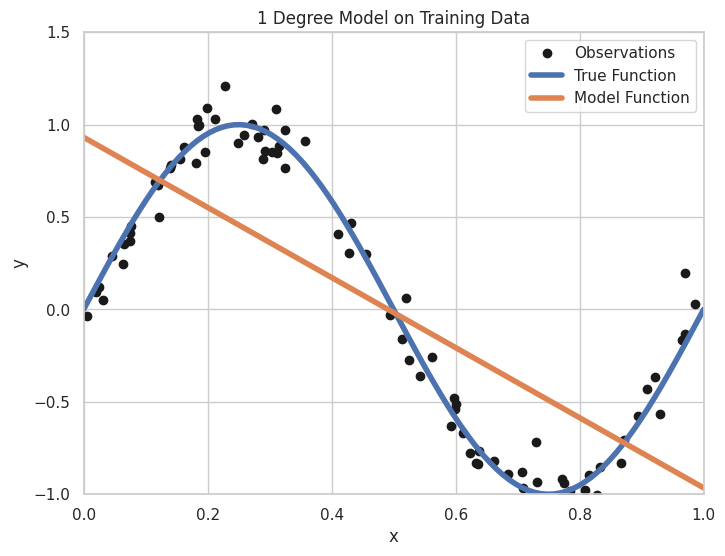

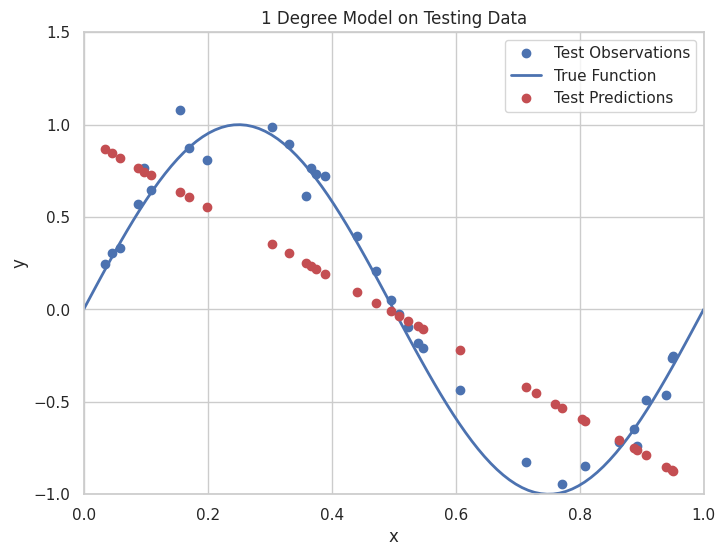

In [19]:
fit_poly(train, y_train, test, y_test, degrees = 1, plot='train')

fit_poly(train, y_train, test, y_test, degrees = 1, plot='test')


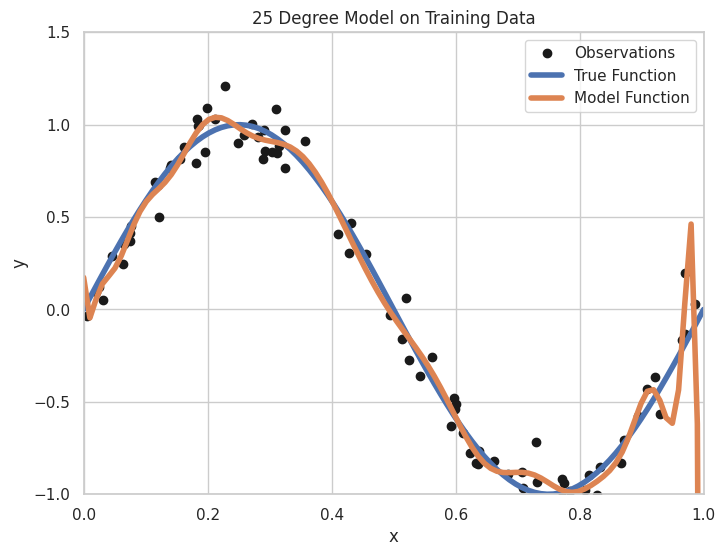

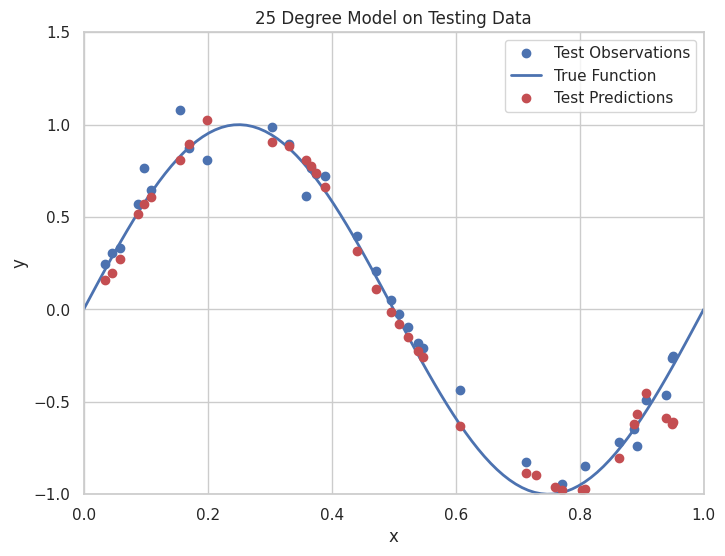

In [20]:
fit_poly(train, y_train, test, y_test, plot='train', degrees = 25)
fit_poly(train, y_train, test, y_test, degrees=25, plot='test')

In [21]:
import pandas as pd

# degrees = [1, 2, 3, 7, 10, 15, 20, 25, 30, 35]
degrees = [int(x) for x in np.linspace(1, 40, 40)]
results = pd.DataFrame(columns=['train_error', 'test_error'], index=degrees)
coefficients = []

# Try each value of degrees for the model and record results
for degree in degrees:
    degree_results = fit_poly(train, y_train, test, y_test, degree, plot=False, return_scores=True)
    results.loc[degree, 'train_error'] = degree_results[0]
    results.loc[degree, 'test_error'] = degree_results[1]

    # Store coefficients in a dictionary with the degree
    coefs = degree_results[2]
    coef_dict = {'degree': degree}
    coef_dict.update({f'coef_{i}': coef for i, coef in enumerate(coefs)})
    coefficients.append(coef_dict)

# Convert the list of dictionaries to a DataFrame
coefficients_df = pd.DataFrame(coefficients)
coefficients_df.fillna(value=0, inplace=True)
coefficients_df.set_index('degree', inplace=True)
coefficients_df = coefficients_df.T
coefficients_df = coefficients_df.applymap(lambda x: f"{x:.2f}")

In [22]:
results

,train_error,test_error
1,0.228933,0.153
2,0.228641,0.151413
3,0.010658,0.009581
4,0.010634,0.009351
5,0.008646,0.009666
6,0.008407,0.010392
7,0.00839,0.010618
8,0.008389,0.010609
9,0.008304,0.010754
10,0.00817,0.011321


In [23]:

desired_degrees = [1, 2, 3, 5, 10, 15, 20, 25, 30, 35, 40]
coefficients_df[desired_degrees]


degree,1,2,3,5,10,15,20,25,30,35,40
coef_0,-1.90,-1.66,12.54,7.76,7.38,-27.09,35.08,-67.75,6.26,291.12,33.66
coef_1,0.00,-0.24,-36.13,-2.96,-58.59,2053.19,-2134.43,7114.41,210.55,-26958.03,-2449.22
coef_2,0.00,0.00,24.20,-63.51,987.76,-55189.98,74868.69,-325974.73,-13729.46,1252375.39,111198.43
coef_3,0.00,0.00,0.00,97.94,-7887.12,805653.13,-1562392.36,8516239.12,307875.10,-34185586.76,-3068955.74
coef_4,0.00,0.00,0.00,-38.95,32664.70,-7216752.08,22051943.97,-140703169.17,-2154966.70,604016413.62,55649637.29
coef_5,0.00,0.00,0.00,0.00,-79709.50,42671574.53,-227542401.60,1571958588.41,-25920753.86,-7330387732.52,-690284607.03
coef_6,0.00,0.00,0.00,0.00,119093.72,-174414973.65,1788921469.32,-12423505829.41,689451114.46,63475878513.93,6001659724.91
coef_7,0.00,0.00,0.00,0.00,-107004.53,506810202.44,-10900877690.64,71567304716.65,-7013259090.88,-401637683188.00,-37106742623.57
coef_8,0.00,0.00,0.00,0.00,53059.59,-1062236139.44,51737042471.97,-305952103996.72,42856809894.90,1880139030277.33,163772609055.96
coef_9,0.00,0.00,0.00,0.00,-11153.32,1610332000.97,-191432481791.24,977090224404.72,-173239314853.55,-6517804665677.96,-510083044634.79


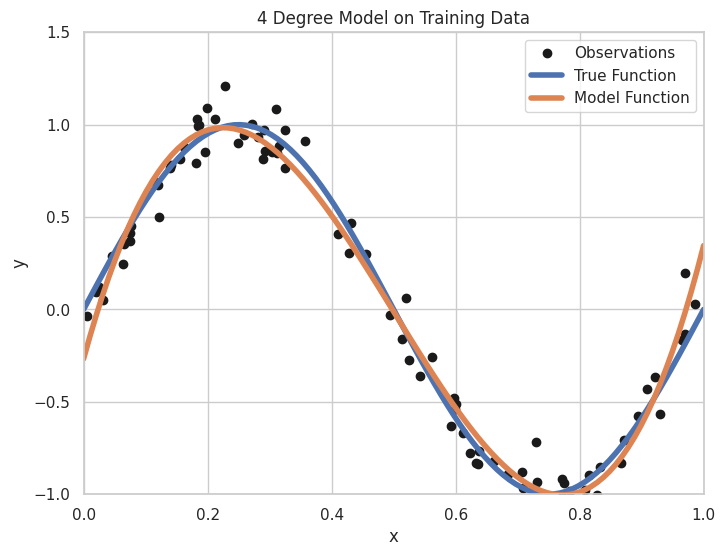

In [24]:
fit_poly(train, y_train, test, y_test, degrees=4, plot='train')

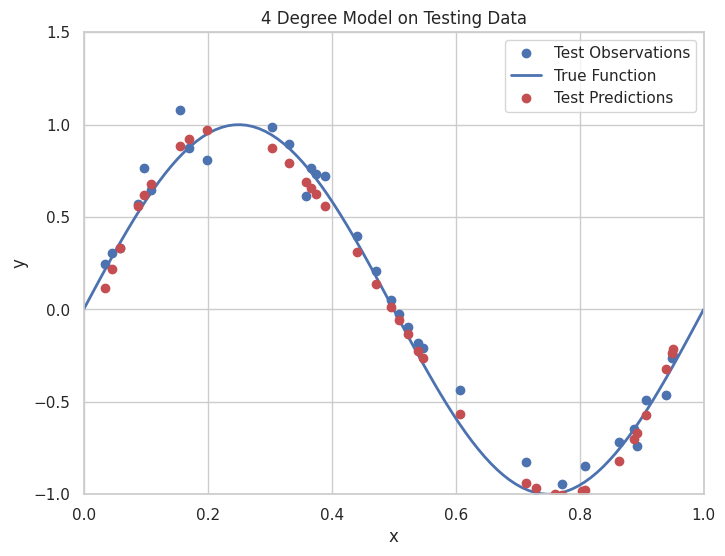

In [25]:
fit_poly(train, y_train, test, y_test, degrees=4, plot='test')

In [26]:
print('10 Lowest Training Errors\n')
train_eval = results.sort_values('train_error').reset_index(level=0).rename(columns={'index': 'degrees'})
train_eval.loc[:,['degrees', 'train_error']] .head(10)

10 Lowest Training Errors



,degrees,train_error
0,36,0.006126
1,35,0.006186
2,40,0.006201
3,39,0.006267
4,31,0.006386
5,32,0.006394
6,28,0.006422
7,27,0.006429
8,33,0.00643
9,29,0.006465


In [27]:
print('10 Lowest Testing Errors\n')
train_eval = results.sort_values('test_error').reset_index(level=0).rename(columns={'index': 'degrees'})
train_eval.loc[:,['degrees', 'test_error']] .head(10)

10 Lowest Testing Errors



,degrees,test_error
0,4,0.009351
1,3,0.009581
2,5,0.009666
3,6,0.010392
4,8,0.010609
5,7,0.010618
6,9,0.010754
7,14,0.011216
8,10,0.011321
9,11,0.011342


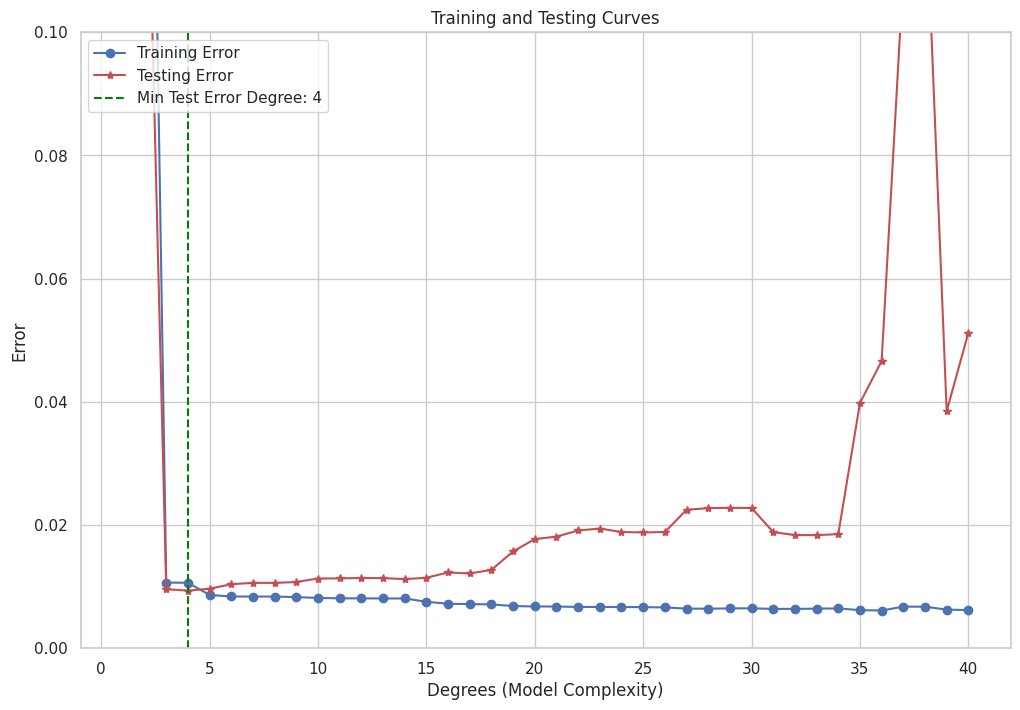


Minimum Training Error occurs at 35 degrees.
Minimum Testing Error occurs at 4 degrees.



In [31]:
plt.figure(figsize=(12, 8))
plt.plot(results.index, results['train_error'], 'b-o', ms=6, label = 'Training Error')
plt.plot(results.index, results['test_error'], 'r-*', ms=6, label = 'Testing Error')
min_test_error_deg = results['test_error'].idxmin()
plt.axvline(min_test_error_deg, color='green', linestyle='--', label=f'Min Test Error Degree: {min_test_error_deg}')
plt.legend(loc=2); plt.xlabel('Degrees (Model Complexity)'); plt.ylabel('Error'); plt.title('Training and Testing Curves');
plt.ylim(0, 0.10); plt.show()

print('\nMinimum Training Error occurs at {} degrees.'.format(int(np.argmin(results['train_error']))))
print('Minimum Testing Error occurs at {} degrees.\n'.format(results['test_error'].idxmin()))

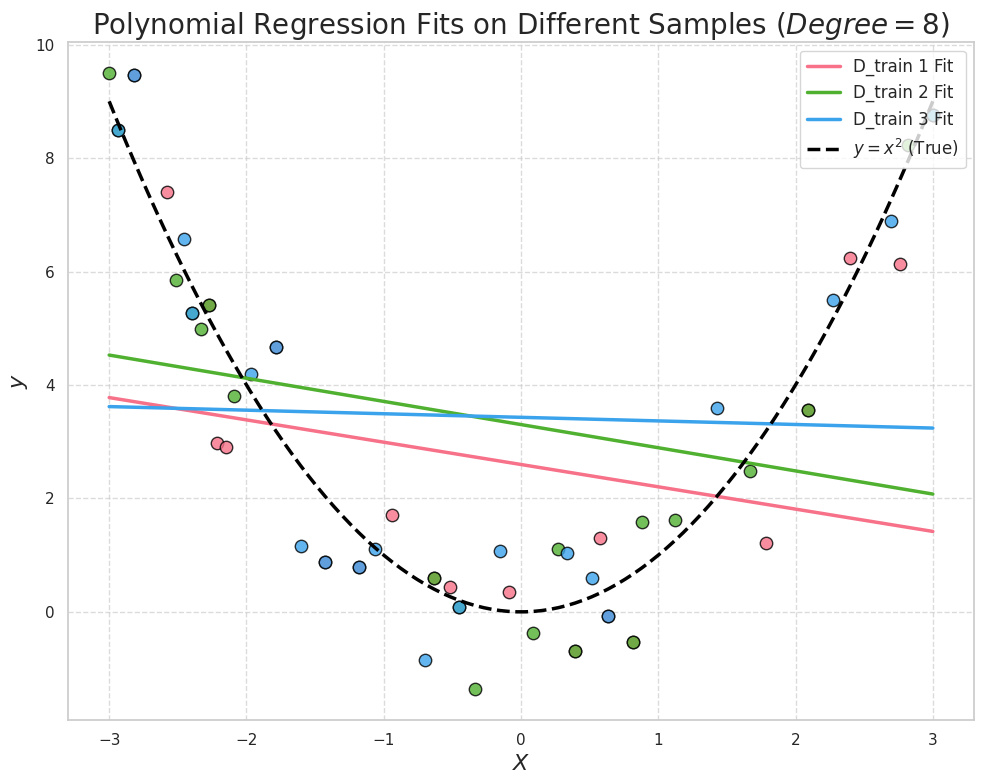

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
import seaborn as sns

# Set Seaborn style
sns.set(style="whitegrid")

# Generate the dataset following y = x^2
np.random.seed(42)
X = np.linspace(-3, 3, 100).reshape(-1, 1)
y = X**2 + np.random.normal(scale=1.0, size=X.shape)  # Adding some noise

# Define the number of samples to draw from the dataset
num_samples = 3
sample_size = 20

# Colors for different samples
colors = sns.color_palette("husl", num_samples)

plt.figure(figsize=(10, 8))

# Train a polynomial regression model (degree 8) on different samples and plot the results
for i in range(num_samples):
    # Randomly select a sample from the dataset
    indices = np.random.choice(range(len(X)), size=sample_size, replace=False)
    X_sample = X[indices]
    y_sample = y[indices]
    
    # Create a polynomial regression model of degree 8
    model = LinearRegression()
    model.fit(X_sample, y_sample)
    
    # Predict y values across the entire range for plotting the fitted curve
    y_pred = model.predict(X)
    
    # Plot the sample data points
    plt.scatter(X_sample, y_sample, color=colors[i], s=80, alpha=0.8, edgecolor='black')
    
    # Plot the fitted polynomial curve
    plt.plot(X, y_pred, color=colors[i], linestyle='-', linewidth=2.5, label=f'D_train {i+1} Fit')

# Plot the original function for reference
plt.plot(X, X**2, color='black', linestyle='--', linewidth=2.5, label=r'$y = x^2$ (True)')

# Enhance the plot with labels, title, and legend
plt.xlabel(r'$X$', fontsize=16)
plt.ylabel(r'$y$', fontsize=16)
plt.title(r'Polynomial Regression Fits on Different Samples ($Degree = 8$)', fontsize=20)
plt.legend(loc='upper right', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

# Display the plot
plt.show()


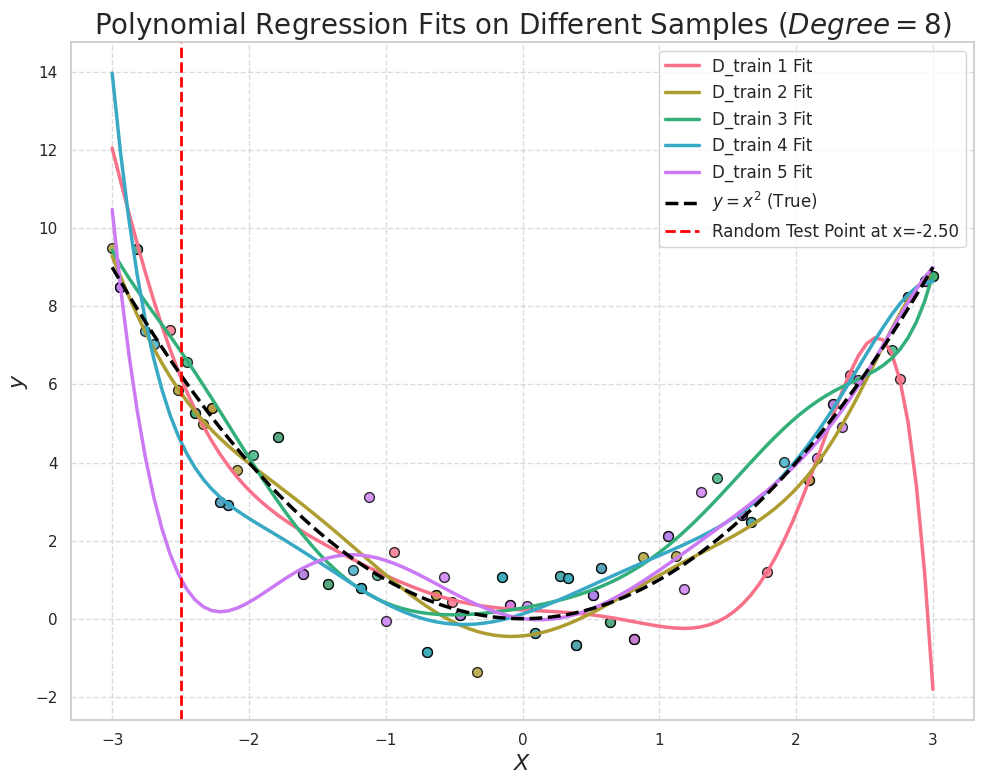

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
import seaborn as sns

# Set Seaborn style
sns.set(style="whitegrid")

# Generate the dataset following y = x^2
np.random.seed(42)
X = np.linspace(-3, 3, 100).reshape(-1, 1)
y = X**2 + np.random.normal(scale=1.0, size=X.shape)  # Adding some noise

# Define the number of samples to draw from the dataset
num_samples = 5
sample_size = 20

# Colors for different samples
colors = sns.color_palette("husl", num_samples)

plt.figure(figsize=(10, 8))

# Train a polynomial regression model (degree 8) on different samples and plot the results
for i in range(num_samples):
    # Randomly select a sample from the dataset
    indices = np.random.choice(range(len(X)), size=sample_size, replace=False)
    X_sample = X[indices]
    y_sample = y[indices]
    
    # Create a polynomial regression model of degree 8
    model = make_pipeline(PolynomialFeatures(degree=8), LinearRegression())
    model.fit(X_sample, y_sample)
    
    # Predict y values across the entire range for plotting the fitted curve
    y_pred = model.predict(X)
    
    # Plot the sample data points
    plt.scatter(X_sample, y_sample, color=colors[i], s=50, alpha=0.8, edgecolor='black')
    
    # Plot the fitted polynomial curve
    plt.plot(X, y_pred, color=colors[i], linestyle='-', linewidth=2.5, label=f'D_train {i+1} Fit')


# Plot the original function for reference
plt.plot(X, X**2, color='black', linestyle='--', linewidth=2.5, label=r'$y = x^2$ (True)')


# Plot a vertical line at the random test point
test_point = -2.5
plt.axvline(x=test_point, color='red', linestyle='--', linewidth=2, label=f'Random Test Point at x={test_point:.2f}')

# Enhance the plot with labels, title, and legend
plt.xlabel(r'$X$', fontsize=16)
plt.ylabel(r'$y$', fontsize=16)
plt.title(r'Polynomial Regression Fits on Different Samples ($Degree = 8$)', fontsize=20)
plt.legend(loc='upper right', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

# Display the plot
plt.show()
